## Get area code for each trip

In [7]:
import osmnx as ox
import pickle
import igraph as ig
import itertools
import time
from compress_pickle import dump as cdump
from compress_pickle import load as cload
import networkx as nx
import osmnx as ox
import pickle
import osmnx as ox
import pickle
import os, sys
import pickle, csv
import numpy as np
import pandas as pd
import glob
import warnings
import geojson
import geopandas as gpd

warnings.filterwarnings("ignore")

In [8]:
df = gpd.read_file("..//..//Database//NYC_area//NYC Taxi Zones.geojson")
df["x"] = df["geometry"].centroid.x
df["y"] = df["geometry"].centroid.y
# see if any two locations has the same location_id
df = df.groupby("location_id").mean().reset_index()
df.location_id = df.location_id.astype(int)
df = df.sort_values(by="location_id")
df

,location_id,x,y
0,1,-74.174000,40.691831
109,2,-73.831299,40.616745
184,3,-73.847422,40.864474
195,4,-73.976968,40.723752
206,5,-74.188484,40.552659
...,...,...,...
175,259,-73.852215,40.897932
177,260,-73.906306,40.744235
178,261,-74.013023,40.709139
179,262,-73.946510,40.775932


In [9]:
# df = df[['location_id','x','y','geometry']]
df.columns = ["oxmid", "x", "y"]

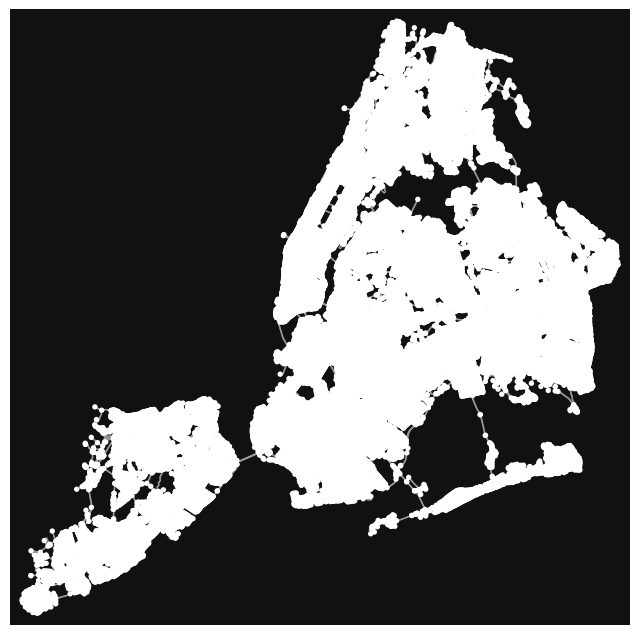

In [10]:
place = ["NYC,NY,USA"]
G = ox.graph_from_place(place, retain_all=True, simplify=True, network_type="drive")
G_projected = ox.project_graph(G)
ox.plot_graph(G_projected)
pickle.dump(G, open("..//..//Database//NYC_area//nyc_ox.pkl", "wb"), pickle.HIGHEST_PROTOCOL)

In [11]:
# Preprocess graph to transform into IGraph
GNSp = pickle.load(open("..//..//Database//NYC_area//nyc_ox.pkl", "rb"), encoding="bytes")
# impute speed on all edges missing data
GNSp = ox.add_edge_speeds(GNSp)
# calculate travel time (seconds) for all edges
GNSp = ox.add_edge_travel_times(GNSp)

# Preprocess graph to transform into IGraph
osmids = list(GNSp.nodes)
GNSp = nx.relabel.convert_node_labels_to_integers(GNSp)

# give each node its original osmid as attribute since we relabeled them
osmid_values = {k: v for k, v in zip(GNSp.nodes, osmids)}
osmid_values_r = {v: k for k, v in osmid_values.items()}
# nx.set_node_attributes(GNSp, osmid_values, "osmid")

# convert networkx graph to igraph
G_ig = ig.Graph(directed=True)
G_ig.add_vertices(GNSp.nodes)
G_ig.add_edges(GNSp.edges())
G_ig.vs["osmid"] = osmids

# Get weights
for w in ["travel_time", "length"]:
    G_ig.es[w] = list(nx.get_edge_attributes(GNSp, w).values())

In [12]:
s = []
# Calculate all routes
for i in range(len(df)):
    s.append(ox.distance.nearest_nodes(GNSp, df["x"][i], df["y"][i], return_dist=False))

In [13]:
# see if any two nodes has the same nearest node
from collections import Counter

b = dict(Counter(s))
print([(key, value) for key, value in b.items() if value > 1])

[]


In [55]:
NYC_area = G_ig.shortest_paths(source=s, target=s, weights="travel_time", mode="out")
print('before imputation',np.sum(np.isinf(NYC_area)))
for i in range(len(NYC_area)):
    for j in range(len(NYC_area)):
        if np.isinf(NYC_area[i][j]) == True and np.isinf(NYC_area[j][i]) == False:
            NYC_area[i][j] = NYC_area[j][i]
print('after imputation',np.sum(np.isinf(NYC_area)))

before imputation 517
after imputation 0


In [60]:
np.save("..//..//Database//NYC_area//NY_area.npy", NYC_area)
print("Done!")
area1 = pd.DataFrame(NYC_area)
area1.columns = df["oxmid"]
area1.index = df["oxmid"]
area1.to_csv("..//..//Database//NYC_area//NY_area_df.csv")
area_list = df["oxmid"]
area_list.to_csv("..//..//Database//NYC_area//NY_area_list.csv")

Done!
